In this assignment you will create a simple network using dense layers.  You will also create 2 more versions of it where you adjust the number of layers and neurons per layer to see if you can achieve better performance.

Task: Create a deep learning model to predict heart disease in populations at risk.  

Data Source: Kaggle Heart Disease Dataset (https://www.kaggle.com/fedesoriano/heart-failure-prediction)

Direct link to data: heart.csv (https://docs.google.com/spreadsheets/d/e/2PACX-1vTRfoQAojPwNsw33zUSpBg32DuK2z0WvLPptGOncIXa38tN3RWk9puvelcmsIIhFb_XF12RD7PdqCwf/pub?output=csv)

TASK: Use a neural network to predict heart disease using the given data.

Make sure you:

1. Explore and clean the data if needed
2. Perform a train-test split on your data
3. Use a column transformer to scale the numeric features and one-hot encode the categorical features.
4. Define your base sequential model
5. Include the number of features of each sample in your input layer
6. Use the correct activation function and the correct number of neurons for your output layer
7. Compile your model with the correct loss function and an optimizer (‘adam’ is a fine choice)
8. Plot your model’s training history.
9. Evaluate your models with appropriate metrics.

After you’ve created, fit, and evaluated your first model, try 2 more versions of it with different numbers of layers and neurons to see if you can create a model that scores better on the testing data.

**Data Dictionary:**

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]




Mount Data

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn import set_config
set_config(display='diagram')



Import Data

In [109]:
heart_df = pd.read_csv('/content/drive/MyDrive/Coding Dojo Data Science Boot Camp/Excel Files/heart - heart.csv')
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Classification Problem

This is a binary classification probelm that will try to determine whether an individual has Heart Disease or Not

# 1) Explore and Clean the data

In [110]:
# Check for any duplicates in the data frame
heart_df.duplicated().any()

False

There are no duplicates

In [111]:
# Check to see if there are any columns with missing data
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


There are no missing columns in the dataset. 

In [112]:
# Look for any numerical inconsistencies / irregularities in the numerical fatures
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


There can be no cholesterol or resting BP of 0. Fasting Blood Sugar is binary as a >120mg/dl is a 1 and <120mg/dl is a 0. Let's drop the zero values for cholesterol and resting BP.

In [113]:
heart_df.loc[heart_df['RestingBP'] == 0, : ]


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


Since this is a singular ro, we will just drop it

In [114]:
heart_df = heart_df.drop(449)
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [115]:
# Check to see if the column was dropped
heart_df.loc[heart_df['RestingBP']== 0, :]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


Now lets look at cholesterol

In [116]:
heart_df.loc[heart_df['Cholesterol']== 0, :]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


We don't have a good way of figuring out what the cholesterol levels should be, but we do know that it can't be 0. There are too many rows with a cholesterol calue of 0 to drop. The best way to approach this, in my opinion is to find out the mean, and replace the 0's with the average cholesterol.

In [117]:
# Find the mean of the cholesterol 
heart_df['Cholesterol'].mean()

199.0163576881134

The average Serum Cholesterol level is 199 mm/dl so we will replace all the 0 counts witht 199

In [118]:
heart_df['Cholesterol'].replace({0 : 199}, inplace = True)

In [119]:
# Check to see if it worked
heart_df.loc[heart_df['Cholesterol'] == 0, :] 

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


Now we will Binarize our columns: Exercise Angina, and Sex

In [120]:
heart_df['Sex'].value_counts()

M    724
F    193
Name: Sex, dtype: int64

In [121]:
heart_df['ExerciseAngina'].value_counts()

N    546
Y    371
Name: ExerciseAngina, dtype: int64

In [122]:
# Binarize sex
heart_df['Sex'] = heart_df['Sex'].map({'M' : 1,
                           'F' : 0})

# Binarize Exercise Angina
heart_df['ExerciseAngina'] = heart_df['ExerciseAngina'].map({'N' : 0,
                                                             'Y' : 1})

In [123]:
# Check to see that the columns were properly binarized
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0


There are no other outliers observed, so  it is time to Perform a Train-Test split on the day

In [124]:
# Identify the Features and target
y = heart_df['HeartDisease']
X = heart_df.drop(columns = 'HeartDisease')

# Perform Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3)

#3) The Next Step is to use a column transformer to scale the numeric features and one-hot encode the categorical features

In [125]:
# Instantiate scaler and One Hot encoder
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

# Make Column Selectors
number_selector = make_column_selector(dtype_include='number')
category_selector = make_column_selector(dtype_include='object')

# Make tuples
number_tuple = (scaler, number_selector)
category_tuple = (ohe, category_selector)

In [126]:
# Create a preprocessing column Transformer with tuples
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f144119c8d0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f144119cbd0>)])

In [127]:
# Fit and transform the preprocessor to the data
X_train_tramsformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Now that the data is is onehot encoded, scaled and fit to the data, we can now define our base sequential model.

In [128]:
# Define our network structur and save the number of features as input shape
input_shape = X_train.shape[1]
input_shape

11

#4) Define Base sequential model

#5) Include the number of features of each sample in your input layer

In [132]:
# Build the model
class_heart_model = Sequential()

# Create a hidden layer
class_heart_model(Dense(11, 
                        input_dim = input_shape,
                        activation = 'relu'))

# Create a second hidden layer
class_heart_model.add(Dense(8,
                            activation = 'relu'))

# 6) Create a porper output layer with the correct function

In [133]:
# Output layer
class_heart_model.add(Dense(1,
                            activation = 'sigmoid'))

# 7) Compile your model with the correct loss function and an optimizer (‘adam’ is a fine choice)

In [134]:
# Compile the model with 'bce' loss function and 'adam' optimizer
class_heart_model.compile(loss = 'bce', optimizer = 'adam', metrics = ['accuracy'])

In [136]:
# Fit the model
history = class_heart_model.fit(X_train_tramsformed, y_train,
                                validation_data = (X_test_transformed, y_test),
                                epochs = 100)

Epoch 1/100
22/22 [==============================] - 7s 198ms/step - loss: 0.6622 - accuracy: 0.6346 - val_loss: 0.6619 - val_accuracy: 0.6174
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.6234 - accuracy: 0.6623 - val_loss: 0.6197 - val_accuracy: 0.6565
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.5917 - accuracy: 0.7045 - val_loss: 0.5813 - val_accuracy: 0.7000
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.5631 - accuracy: 0.7278 - val_loss: 0.5501 - val_accuracy: 0.7348
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.5388 - accuracy: 0.7380 - val_loss: 0.5224 - val_accuracy: 0.7696
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.5167 - accuracy: 0.7613 - val_loss: 0.4991 - val_accuracy: 0.8000
Epoch 7/100
22/22 [==============================] - 3s 133ms/step - loss: 0.4973 - accuracy: 0.7846 - val_loss: 0.4771 - val_accuracy: 0.8130
Epoch 8/1

#8) Plot your model’s training history.

In [139]:
# Write a function to plot the models history
def plot_hist(history, metric = None):
  """metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (8,8))
  axes[0].plot(history.history['loss'], label = 'Training Loss')
  axes[0].plot(history.history['val_loss'], label = 'Testing Loss')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'Training loss')
    axes[1].plot(history.history['val_' + metric], label = 'Testing Loss')
    axes[1].set_title(metric)
    axes[1].legend()
  plt.show()

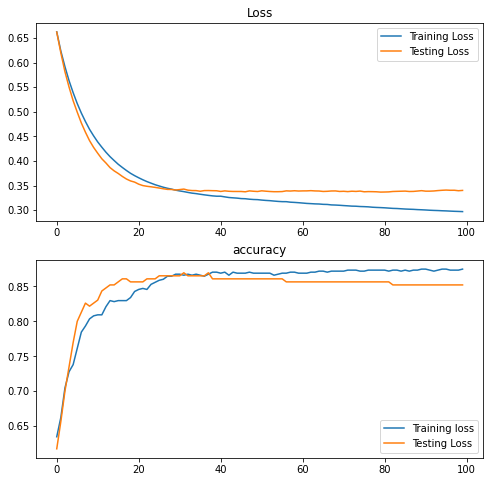

In [140]:
# Plot the history
plot_hist(history, 'accuracy')

# 9) Evaluate your models with appropriate metrics

In [141]:
# Make predictions and evaluate your model
predictions = class_heart_model.predict(X_test_transformed)
pred_processed = np.rint(predictions)
print(classification_report(y_test, pred_processed))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       119
           1       0.82      0.89      0.85       111

    accuracy                           0.85       230
   macro avg       0.85      0.85      0.85       230
weighted avg       0.86      0.85      0.85       230



Witht the classification report, we can see that our model has an accuracy score of 85%

After you’ve created, fit, and evaluated your first model, try 2 more versions of it with different numbers of layers and neurons to see if you can create a model that scores better on the testing data.

In [166]:
# Version 2 
heart_model2 = Sequential()

# First Hidden Layer
heart_model2(Dense(11, input_dim = input_shape, activation = 'relu'))

# Second Hidden Layer
heart_model2.add(Dense(8, activation = 'relu'))

# Third Hidden Layer 
heart_model2.add(Dense(4, activation = 'relu'))

# Output layer
heart_model2.add(Dense(1, activation= 'sigmoid'))

In [167]:
# Compile Model
heart_model2.compile(loss = 'bce', optimizer = 'adam', metrics = 'accuracy')

In [171]:
# Fit the model
history2 = heart_model2.fit(X_train_tramsformed, y_train,
                                validation_data = (X_test_transformed, y_test),
                                epochs = 100)

Epoch 1/100
22/22 [==============================] - 2s 8ms/step - loss: 0.3444 - accuracy: 0.8559 - val_loss: 0.3464 - val_accuracy: 0.8478
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.3424 - accuracy: 0.8588 - val_loss: 0.3450 - val_accuracy: 0.8478
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.3411 - accuracy: 0.8603 - val_loss: 0.3454 - val_accuracy: 0.8478
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.3395 - accuracy: 0.8632 - val_loss: 0.3444 - val_accuracy: 0.8522
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.3382 - accuracy: 0.8617 - val_loss: 0.3431 - val_accuracy: 0.8522
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3371 - accuracy: 0.8646 - val_loss: 0.3429 - val_accuracy: 0.8522
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.3357 - accuracy: 0.8646 - val_loss: 0.3413 - val_accuracy: 0.8478
Epoch 8/100
2

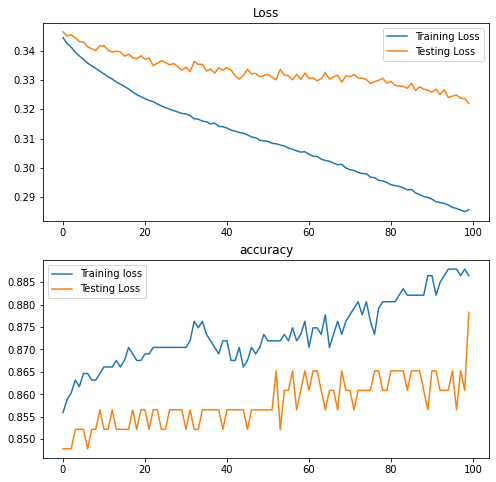

In [172]:
# Plot the history of the second model
plot_hist(history2, 'accuracy')

In [173]:
# Make predictions and evaluate your model
model_2_pred = np.rint(heart_model2.predict(X_test_transformed))
print(classification_report(y_test, model_2_pred))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       119
           1       0.84      0.92      0.88       111

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



A third layer with 4 nuerons imroved our accuracy score to 88. Let's add a 4th hidden layer with 2 nuerons to see if we can get closer to 90.

In [179]:
# Version 3
heart_model3 = Sequential()

# First Hiddent Layer
heart_model3(Dense(11, input_dim = input_shape, activation = 'relu'))

# Second Hidden Layer
heart_model3.add(Dense(8, activation = 'relu'))

# Third Hidden Layer
heart_model3.add(Dense(4, activation = 'relu'))

# Fourth Hidden Layer
heart_model3.add(Dense(2, activation = 'relu'))

# Output layer
heart_model3.add(Dense(1, activation = 'sigmoid'))

In [180]:
# Compile the model
heart_model3.compile(loss = 'bce', optimizer= 'adam', metrics = ['accuracy'])

In [181]:
# Fit the model
history3 = heart_model3.fit(X_train_tramsformed, y_train,
                            validation_data = (X_test_transformed, y_test),
                            epochs = 100)

Epoch 1/100
22/22 [==============================] - 3s 118ms/step - loss: 0.6768 - accuracy: 0.5633 - val_loss: 0.6847 - val_accuracy: 0.4826
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.5764 - val_loss: 0.6665 - val_accuracy: 0.4826
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.5764 - val_loss: 0.6443 - val_accuracy: 0.4826
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6054 - accuracy: 0.5764 - val_loss: 0.6206 - val_accuracy: 0.4826
Epoch 5/100
22/22 [==============================] - 3s 125ms/step - loss: 0.5775 - accuracy: 0.5764 - val_loss: 0.5988 - val_accuracy: 0.4826
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.5518 - accuracy: 0.5895 - val_loss: 0.5811 - val_accuracy: 0.6652
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.5299 - accuracy: 0.7627 - val_loss: 0.5656 - val_accuracy: 0.7043
Epoch 8/1

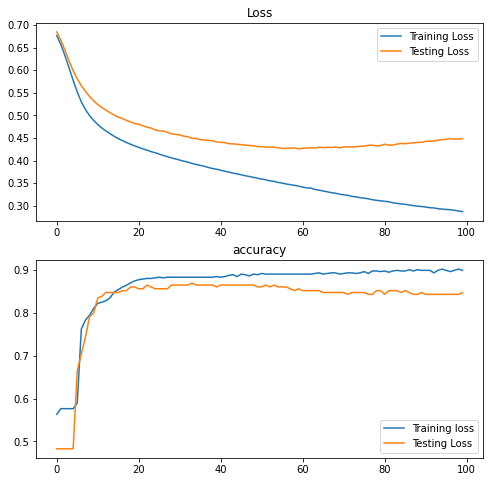

In [182]:
# Plot the model
plot_hist(history3, 'accuracy')

In [183]:
model_3_pred = np.rint(heart_model3.predict(X_test_transformed))
print(classification_report(y_test, model_3_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       119
           1       0.85      0.83      0.84       111

    accuracy                           0.85       230
   macro avg       0.85      0.85      0.85       230
weighted avg       0.85      0.85      0.85       230



Adding a fourth hidden layer of 2 nuerons actually decreased the accuracy score from 88% to 85%.